In [71]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random
from collections import defaultdict
import numpy as np
import onnxruntime
import torch.nn.functional as torch_func
from torchvision.transforms.functional import rotate, affine, resize, center_crop
from PIL import Image
import cv2

random.seed(42)

In [72]:
from models.allcnn2d import AllCNN2D, AllCNN2D_Prod
from drawing.interactive import draw_image

# Global

In [73]:
DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

# Paths

In [74]:
file_path: str = os.path.abspath(".")
root_path: str = os.path.join(file_path, os.pardir, os.pardir)
checkpoint_path: str = os.path.join(
    root_path, 
    "checkpoints", 
    "GeckoFull_epoch1980_trainacc0.90605_valacc0.98089_Tloss0.78068_Vloss0.20101_lr6.320194197753456e-11.pkl"
)


# Load Model

In [75]:
alphabet: list[str] = ['(', ')', '+', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'λ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '×', '÷']

model: AllCNN2D_Prod = AllCNN2D_Prod(
    labels_map=alphabet,
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cpu",
        "conv_dropout": 0.0,
        "verbose": True,
        "name_prefix": "GeckoFinal",
        #"checkpoint_path": checkpoint_path
    }

).eval()

Layer (type:depth-idx)                   Output Shape              Param #
AllCNN2D_Prod                            [1, 44]                   --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 64, 64]           160
│    │    └─Dropout2d: 3-2               [1, 16, 64, 64]           --
│    │    └─BatchNorm2d: 3-3             [1, 16, 64, 64]           32
│    │    └─LeakyReLU: 3-4               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,320
│    │    └─Dropout2d: 3-6               [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    │    └─LeakyReLU: 3-8               [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-9                  [1, 32, 32, 32]           4,640
│    │  

In [76]:
[(i, char, ord(char)) for i, char in enumerate(alphabet)]

[(0, '(', 40),
 (1, ')', 41),
 (2, '+', 43),
 (3, '-', 45),
 (4, '.', 46),
 (5, '0', 48),
 (6, '1', 49),
 (7, '2', 50),
 (8, '3', 51),
 (9, '4', 52),
 (10, '5', 53),
 (11, '6', 54),
 (12, '7', 55),
 (13, '8', 56),
 (14, '9', 57),
 (15, 'λ', 955),
 (16, 'a', 97),
 (17, 'b', 98),
 (18, 'c', 99),
 (19, 'd', 100),
 (20, 'e', 101),
 (21, 'f', 102),
 (22, 'g', 103),
 (23, 'h', 104),
 (24, 'i', 105),
 (25, 'j', 106),
 (26, 'k', 107),
 (27, 'l', 108),
 (28, 'm', 109),
 (29, 'n', 110),
 (30, 'o', 111),
 (31, 'p', 112),
 (32, 'q', 113),
 (33, 'r', 114),
 (34, 's', 115),
 (35, 't', 116),
 (36, 'u', 117),
 (37, 'v', 118),
 (38, 'w', 119),
 (39, 'x', 120),
 (40, 'y', 121),
 (41, 'z', 122),
 (42, '×', 215),
 (43, '÷', 247)]

In [77]:

# Create a dummy input tensor
dummy_input = torch.randn(1, 1, 64, 64)  # Example input

# Define the ONNX file path
onnx_file_path = "model.onnx"

# Export the model
torch.onnx.export(
    model,
    dummy_input,
    onnx_file_path,
    input_names=["input"],  # Name of the input layer
    output_names=["logits", "softmax", "softmax_ordered"],  # Names of the output layers
    dynamic_axes={"input": {0: "batch_size"},  # Variable batch size
                  "logits": {0: "batch_size"},
                  "softmax": {0: "batch_size"},
                  "softmax_ordered": {0: "batch_size"}},
    opset_version=11  # Specify the ONNX opset version
)

print(f"Model saved to {onnx_file_path}")

Model saved to model.onnx


c:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\src\cnn\models\allcnn2d.py:573: TracerWarning: Converting a tensor to a Python list might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  softmaxed_char.tolist(),
c:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\src\cnn\models\allcnn2d.py:585: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  softmax_ordered: Tensor = tensor(


# Load Onnx

In [78]:


# Load the ONNX model
model_path = "model.onnx"
session = onnxruntime.InferenceSession(model_path)

input_image = np.random.random(
    (
        1,  # batch: stack as many images as you like here
        1,  # channels: needs to be 1 (grayscale), pixels are 1.0 or 0.0
        64, # height: fixed to 64 pixels for now
        64  # width: fixed to 64 pixels for now
    )
).astype(np.float32)

# Run inference
inputs: list[onnxruntime.NodeArg] = session.get_inputs()
outputs: list[onnxruntime.NodeArg] = session.get_outputs()

input_name: list[str] = inputs[0].name
output_names: list[str] = [out.name for out in outputs]


In [79]:

softmax: np.ndarray
softmax_ordered: np.ndarray
logits: np.ndarray

logits, softmax, softmax_ordered = session.run(
    output_names, 
    {input_name: input_image}
)

# logits.shape is shape (batch, character) for all character labels
# softmax.shape is shape (batch, character) for all character labels
# softmax_ordered is shape (batch, character, [label index, label prob, unicode character value])

# character dim is 44 (there are 44 character labels)
# label index is from 0 to 44 (corresponding to each ordered label index)
# label prob is a softmaxed probability for this label prediction
# unicode character value is the unicode character for this prediction



In [80]:
logits.shape, softmax.shape, softmax_ordered.shape

((1, 44), (1, 44), (1, 44, 3))

In [81]:


top_character_probs: list[list[float]] = softmax_ordered[:, :, 1].tolist()

top_characters: list[list[str]] = [
    [
        chr(int(softmax_ordered[batch_i, i, 2])) 
        for i in range(softmax_ordered.shape[1])
    ] for batch_i in 
    range(softmax_ordered.shape[0])
]


# Hello World

In [82]:
class TextReShitter(nn.Module):
    
    def __init__(self, alphabet: list[str], text: str):
        
        super(TextReShitter, self).__init__()
        
        self.alphabet: list[str] = sorted(alphabet)
        self.text: str = text
        
        self.logits: list[torch.Tensor] = []
        
        for c in self.text:
            c_index: int = self.alphabet.index(c)
            
            char_logits: torch.Tensor = torch.rand((len(alphabet),))
            char_logits[c_index] += 2
            char_logits *= (torch.rand(1)+0.1)

            self.logits.append(char_logits)

        self.logits_tensor: torch.Tensor = torch.stack(self.logits, dim=0)
        
        self.logits_tensor = self.logits_tensor.unsqueeze(0) # batch, chars, logit
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        self.logits_tensor = self.logits_tensor + x.sum() * 0.0  

        softmax = torch.softmax(self.logits_tensor, dim=-1)
        
        # Create indices for the first dimension (char_prob_i)
        char_prob_indices = torch.arange(softmax.size(-1), device=softmax.device).reshape(1, 1, -1, 1)
        
        # Create indices for the third dimension (ord(self.alphabet[char_prob_i]))
        alphabet_indices = torch.tensor([ord(c) for c in self.alphabet], device=softmax.device).reshape(1, 1, -1, 1)
        
        # Expand dimensions to match softmax shape
        char_prob_indices = char_prob_indices.expand(*softmax.shape, 1)
        alphabet_indices = alphabet_indices.expand(*softmax.shape, 1)
        
        # Concatenate along the last dimension
        softmax_ordered = torch.cat([char_prob_indices, softmax.unsqueeze(-1), alphabet_indices], dim=-1)
        
        # Sort along the probability dimension (dim=-2)
        sorting_indices = softmax_ordered[..., 1].argsort(dim=-1, descending=True)
        sorted_tensor = torch.gather(softmax_ordered, -2, sorting_indices.unsqueeze(-1).expand(-1, -1, -1, 3))
        
        x = x * 0.5
        
        return self.logits_tensor, softmax, sorted_tensor
        
        
        

In [83]:
hello_world_model = TextReShitter(alphabet, "hello.world")

logits, softmax, softmax_ord = hello_world_model.forward(torch.zeros(1, 1, 1, 1))

logits.shape, softmax.shape, softmax_ord.shape

(torch.Size([1, 11, 44]), torch.Size([1, 11, 44]), torch.Size([1, 11, 44, 3]))

# ONNX: Save Hello World

In [84]:
# Create a dummy input tensor
dummy_input = torch.randn(1, 1, 1, 1)  # Example input

# Define the ONNX file path
onnx_file_path = "hello_world.onnx"

# Export the model
torch.onnx.export(
    hello_world_model,
    dummy_input,
    onnx_file_path,
    input_names=["input"],  # Name of the input layer
    output_names=["logits", "softmax", "softmax_ordered"],  # Names of the output layers
    dynamic_axes={"input": {0: "batch_size", 2: "height", 3: "width"},  # Variable batch size
                  "logits": {0: "batch_size"},
                  "softmax": {0: "batch_size"},
                  "softmax_ordered": {0: "batch_size"}},
    opset_version=11  # Specify the ONNX opset version
)

print(f"Model saved to {onnx_file_path}")

Model saved to hello_world.onnx


C:\Users\Leon\AppData\Local\Temp\ipykernel_20432\3231084438.py:35: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  alphabet_indices = torch.tensor([ord(c) for c in self.alphabet], device=softmax.device).reshape(1, 1, -1, 1)


# Load Hello World Onnx

In [85]:

# Load the ONNX model
model_path = "hello_world_dyn.onnx"
session = onnxruntime.InferenceSession(model_path)

input_image = np.random.random(
    (
        1,  # batch: stack as many images as you like here
        1,  # channels: needs to be 1 (grayscale), pixels are 1.0 or 0.0
        2,  # height: fixed to 1 for now
        1   # width: fixed to 1 for now
    )
).astype(np.float32)

# Run inference
inputs: list[onnxruntime.NodeArg] = session.get_inputs()
outputs: list[onnxruntime.NodeArg] = session.get_outputs()

input_name: str = inputs[0].name
output_names: list[str] = [out.name for out in outputs]
softmax: np.ndarray
softmax_ordered: np.ndarray
logits: np.ndarray

logits, softmax, softmax_ordered = session.run(
    output_names, 
    {input_name: input_image}
)

top3_preds: np.ndarray = softmax_ordered[:, :, :3, 2] # top three predictions for each character (unicode value, convert to string with chr)
top3_pred_probs: np.ndarray = softmax_ordered[:, :, :3, 1] # top three prediction probabilities

print(top3_preds)

print(top3_pred_probs)

for letter_i in range(top3_preds.shape[1]):
    for k in range(3):
        
        pred_percentage: float = top3_pred_probs[0, letter_i, k]*100
        
        print(f"#{k+1} @ {pred_percentage:.4}% - {chr(int(top3_preds[0, letter_i, k]))}")
    print("--")


[[[104. 120. 115.]
  [101. 105. 109.]
  [108.  45. 118.]
  [108.  50.  55.]
  [111. 247.  41.]
  [ 46. 111.  52.]
  [119. 104. 118.]
  [111. 117.  53.]
  [114.  57.  45.]
  [108.  97. 112.]
  [100. 111. 104.]]]
[[[0.13487485 0.03051421 0.03024892]
  [0.03483254 0.02470074 0.0245183 ]
  [0.12618831 0.03325844 0.03256983]
  [0.14055243 0.02988121 0.02889052]
  [0.03572701 0.02537489 0.02510708]
  [0.0649533  0.0259773  0.02597003]
  [0.03041911 0.02436568 0.02433025]
  [0.09235369 0.03029493 0.03025205]
  [0.08532248 0.03095609 0.0284572 ]
  [0.03220282 0.02440088 0.02422533]
  [0.02972033 0.02469328 0.0244364 ]]]
#1 @ 13.49% - h
#2 @ 3.051% - x
#3 @ 3.025% - s
--
#1 @ 3.483% - e
#2 @ 2.47% - i
#3 @ 2.452% - m
--
#1 @ 12.62% - l
#2 @ 3.326% - -
#3 @ 3.257% - v
--
#1 @ 14.06% - l
#2 @ 2.988% - 2
#3 @ 2.889% - 7
--
#1 @ 3.573% - o
#2 @ 2.537% - ÷
#3 @ 2.511% - )
--
#1 @ 6.495% - .
#2 @ 2.598% - o
#3 @ 2.597% - 4
--
#1 @ 3.042% - w
#2 @ 2.437% - h
#3 @ 2.433% - v
--
#1 @ 9.235% - o
#2 @ 3.0

# Create CNN Production

In [166]:


class KrudModel(nn.Module):
    
    def __init__(
        self, 
        alphabet: list[str], 
        target_width: int = 64, 
        target_height: int = 64, 
        padding: int = 1,
        model: torch.nn.Module = None
    ):
        
        super(KrudModel, self).__init__()
        
        self.alphabet: list[str] = sorted(alphabet)
        self.alphabet_float: torch.Tensor = torch.tensor([ord(a) for a in self.alphabet], dtype=torch.float32) 
        self.target_width: int = target_width
        self.target_height: int = target_height
        self.padding: int = padding
        self._unpadded_dims: tuple[int] = (
            self.target_height-self.padding*2,
            self.target_width-self.padding*2
        )
        self.model: torch.nn.Module = model.eval()
    
        
    def preprocess_image(
        self, 
        im: torch.Tensor
    ) -> torch.Tensor:
        """
        Preprocesses the input image by cropping, resizing, binarizing, and padding it.

        Args:
            im (torch.Tensor): Input image tensor of shape (C, H, W) or (B, C, H, W).

        Returns:
            torch.Tensor: Preprocessed image tensor.
        """
        # Step 1: Binarize the image (foreground = 0, background = 1)
        mask = im > 0.5

        # Step 2: Find bounding box coordinates of the foreground
        coords = torch.nonzero(mask)  # Get coordinates of non-zero (foreground) pixels

        # Step 3: Check if there are any foreground pixels (traceable)
        has_foreground = torch.any(mask)

        # Step 4: Compute min and max coordinates for cropping (if foreground exists)
        min_coords = torch.where(
            has_foreground,
            coords.min(dim=0)[0],
            torch.tensor([0, 0, 0, 0], device=im.device)  # Default value if no foreground
        )
        max_coords = torch.where(
            has_foreground,
            coords.max(dim=0)[0],
            torch.tensor([0, 0, im.size(2) - 1, im.size(3) - 1], device=im.device)  # Default value if no foreground
        )

        # Step 5: Extract min and max coordinates for height and width (assuming input is 4D: B, C, H, W)
        min_x, min_y = min_coords[2], min_coords[3]
        max_x, max_y = max_coords[2], max_coords[3]

        # Step 6: Crop the image (use slicing, which is traceable)
        im = im[:, :, min_x:max_x + 1, min_y:max_y + 1]

        # Step 7: Resize the image to the desired dimensions
        im = torch_func.interpolate(
            im, 
            size=self._unpadded_dims, 
            mode="bilinear", 
            align_corners=False
        )

        # Step 8: Binarize the image again (optional, depending on your use case)
        im = (im > 0.5).type(torch.uint8).type(torch.float32)

        # Step 9: Pad the image
        im = torch_func.pad(
            im,
            (self.padding, self.padding, self.padding, self.padding),
            mode='constant',
            value=0.0
        )

        return im
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.preprocess_image(x)
        
        #plt.imshow(x.squeeze(), cmap="gray")
        #plt.show()
        
        y_hat: torch.Tensor = self.model(x)
        y_hat = y_hat.squeeze().squeeze()
        
        softmax = torch.softmax(y_hat, dim=-1)
        
        stacked = torch.stack([self.alphabet_float, softmax], dim=1)
        sorted_indices = torch.argsort(stacked[:, 1], descending=True)
        sorted_tensor = stacked[sorted_indices]

        return sorted_tensor
        
        
       

label_map: list[str] = ['(', ')', '+', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'λ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '×', '÷']

checkpoint_path: str = os.path.join(
    root_path, 
    "checkpoints", 
    "Krud_epoch29_trainacc0.93466_valacc0.97159_Tloss0.013132_Vloss0.0056677_lr0.0007224.pkl"
)

model: AllCNN2D = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cpu",
        "conv_dropout": 0.0,
        "verbose": True,
        "name_prefix": "KrudEval",
        "checkpoint_path": checkpoint_path
    }

).eval()
krud_model: KrudModel = KrudModel(
    label_map,
    model=model
)

dummy_input = torch.randn(1, 1, 100, 100)  # Example input

# Define the ONNX file path
onnx_file_path = "char_model_lamda_calculus.onnx"

# Export the model
torch.onnx.export(
    krud_model,
    dummy_input,
    onnx_file_path,
    input_names=["input"],  # Name of the input layer
    output_names=["softmax_ordered"],  # Names of the output layers
    dynamic_axes={"input": {2: "height", 3: "width"}},
    opset_version=11  # Specify the ONNX opset version
)

print(f"Model saved to {onnx_file_path}")

Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

C:\Users\Leon\AppData\Local\Temp\ipykernel_20432\4192116138.py:52: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.tensor([0, 0, 0, 0], device=im.device)  # Default value if no foreground
C:\Users\Leon\AppData\Local\Temp\ipykernel_20432\4192116138.py:57: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  torch.tensor([0, 0, im.size(2) - 1, im.size(3) - 1], device=im.device)  # Default value if no foreground


In [167]:

plus_im: np.ndarray = np.asarray(Image.open(r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\data\lambda\u2b-1736974496947.png"))

plus_im = plus_im[:, :, 3]


plus_im = plus_im.astype(np.float32)/255

plus_im_ten = torch.tensor(plus_im, dtype=torch.float32).unsqueeze(0).unsqueeze(0)


krud_model.forward(plus_im_ten)


tensor([[4.3000e+01, 9.3858e-01],
        [2.4700e+02, 5.7565e-02],
        [9.5500e+02, 1.5453e-03],
        [5.5000e+01, 1.4862e-03],
        [1.2100e+02, 5.4839e-04],
        [9.7000e+01, 1.8937e-04],
        [1.0300e+02, 4.8974e-05],
        [1.2200e+02, 2.8834e-05],
        [1.0500e+02, 1.5799e-06],
        [1.0800e+02, 8.6764e-07],
        [5.2000e+01, 6.3947e-07],
        [1.1700e+02, 1.6689e-07],
        [1.0100e+02, 1.0515e-07],
        [4.9000e+01, 9.0722e-08],
        [2.1500e+02, 6.1379e-08],
        [1.1000e+02, 4.4690e-08],
        [1.1400e+02, 3.3480e-08],
        [5.7000e+01, 1.2193e-08],
        [1.1500e+02, 3.4486e-09],
        [1.1900e+02, 9.5328e-10],
        [5.3000e+01, 3.0586e-10],
        [5.6000e+01, 1.8158e-10],
        [9.8000e+01, 1.6832e-10],
        [1.2000e+02, 7.8394e-11],
        [4.5000e+01, 4.7620e-11],
        [1.1100e+02, 3.2993e-11],
        [5.1000e+01, 1.9548e-11],
        [1.1300e+02, 5.6589e-12],
        [1.0600e+02, 2.6825e-12],
        [1.040

# Test Krud ONNX

In [100]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt 
import onnxruntime

In [149]:

input_image = Image.open("test_im.png")

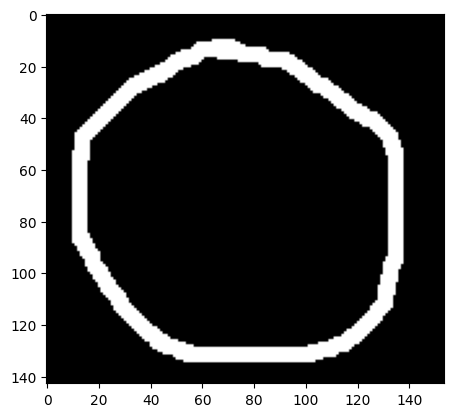

In [150]:
test_image = np.asarray(input_image)
test_image = ((1.0-test_image[:, :, 0]/255) > 0.5).astype(np.uint8)*1.0

plt.imshow(test_image, cmap="gray")
plt.show()

test_image = np.expand_dims(np.expand_dims(test_image, 0), 0)


In [174]:
test_image.shape

(1, 1, 143, 154)

In [178]:
test_image

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])

In [179]:

# Load the ONNX model
model_path = "char_model_lamda_calculus_v2.onnx"
session = onnxruntime.InferenceSession(model_path)

# Run inference
inputs: list[onnxruntime.NodeArg] = session.get_inputs()
outputs: list[onnxruntime.NodeArg] = session.get_outputs()

input_name: str = inputs[0].name            # Only one input 
output_name: list[str] = outputs[0].name    # Only one output [unicode, prob] pairs for a single character

model_outputs = session.run(
    [output_name], 
    {input_name: test_image.astype(np.float32)} # Must be float32 image of shape (batch, channels, height, width) -> (1, 1, Any, Any)
)[0]

# model_outputs.shape = (characters, alphabet_size, [unicode, prob]) -> (1, 44, 2)

softmax_ordered = model_outputs[0, :, :]
probs: np.ndarray = softmax_ordered[:, 1]
chars: np.ndarray = softmax_ordered[:, 0]

for char, prob in zip(chars, probs):
    print(chr(int(char)), prob)

0 0.68143886
p 0.31727558
d 0.0009891384
6 0.0001600089
t 5.1013758e-05
8 2.8218346e-05
5 2.4816827e-05
o 8.780571e-06
q 5.5376886e-06
f 3.6561419e-06
b 3.0133053e-06
( 2.676651e-06
w 2.4739402e-06
m 1.5798223e-06
k 1.5708143e-06
j 8.663088e-07
h 6.861411e-07
n 5.575756e-07
2 4.7443012e-07
c 3.30369e-07
x 6.3471326e-08
r 2.9459986e-08
× 2.2759442e-08
3 1.8600712e-08
- 1.800039e-08
1 1.2019766e-08
v 3.3489278e-09
9 3.006773e-09
g 2.6663645e-09
z 2.0556845e-09
i 1.1345208e-09
e 3.8724163e-10
) 2.8197075e-10
s 1.6642417e-10
u 3.9026893e-11
y 1.4455865e-11
7 1.027535e-11
a 8.538898e-12
. 2.8815811e-13
4 2.1714051e-13
l 4.009424e-14
÷ 2.7764098e-14
λ 2.0496294e-15
+ 9.230513e-16


(['0', 'p', 'd'], array([ 48., 112., 100.], dtype=float32))

In [153]:
model_outputs

array([[[4.8000000e+01, 6.8143886e-01],
        [1.1200000e+02, 3.1727558e-01],
        [1.0000000e+02, 9.8913838e-04],
        [5.4000000e+01, 1.6000890e-04],
        [1.1600000e+02, 5.1013758e-05],
        [5.6000000e+01, 2.8218346e-05],
        [5.3000000e+01, 2.4816827e-05],
        [1.1100000e+02, 8.7805711e-06],
        [1.1300000e+02, 5.5376886e-06],
        [1.0200000e+02, 3.6561419e-06],
        [9.8000000e+01, 3.0133053e-06],
        [4.0000000e+01, 2.6766511e-06],
        [1.1900000e+02, 2.4739402e-06],
        [1.0900000e+02, 1.5798223e-06],
        [1.0700000e+02, 1.5708143e-06],
        [1.0600000e+02, 8.6630882e-07],
        [1.0400000e+02, 6.8614111e-07],
        [1.1000000e+02, 5.5757562e-07],
        [5.0000000e+01, 4.7443012e-07],
        [9.9000000e+01, 3.3036901e-07],
        [1.2000000e+02, 6.3471326e-08],
        [1.1400000e+02, 2.9459986e-08],
        [2.1500000e+02, 2.2759442e-08],
        [5.1000000e+01, 1.8600712e-08],
        [4.5000000e+01, 1.8000391e-08],


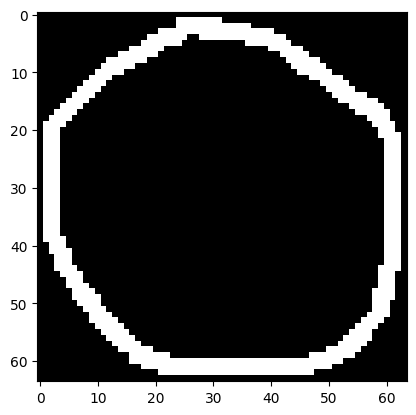

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [154]:
preds = krud_model.eval().forward(torch.tensor(test_image.astype(np.float32)))[:, 0].tolist()

[chr(int(x)) for x in preds]